In [33]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

#### 3.3) Support Vector Machines
- - -

In [12]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


In [13]:
# define helper functions
def get_coords_for_country(country):
    country_row = df.loc[df["Country/Region"] == country]
    return country_row["Lat"].unique()[0], country_row["Long"].unique()[0]

get_coords_for_country("Afghanistan")

(33.0, 65.0)

In [14]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [15]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [16]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

print(np.any(np.isnan(in_conf_train)))
print(np.all(np.isfinite(in_conf_train)))
print(np.any(in_conf_train >= np.finfo(np.float64).max))
print()
print(np.any(np.isnan(out_conf_train)))
print(np.all(np.isfinite(out_conf_train)))
print(np.any(out_conf_train >= np.finfo(np.float64).max))

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

False
True
False

False
True
False


In [17]:
svm = SVR()
svm.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [31]:
# do hyper parameter tuning with the Multi-layer Perceptron, using cross validation

param_grid = {
    'C': [0.01, 0.1, 1], 
    'gamma' : [0.01, 0.1, 1], 
    'epsilon': [0.01, 0.1, 1], 
    'shrinking' : [True, False], 
    'degree': [3, 4, 5]
}

#grid_search = RandomizedSearchCV(svm, param_grid, n_jobs=-1, cv=3, verbose=2)
#grid_search.fit(in_conf_train, out_conf_train)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#grid_search.best_estimator_
#svm_estimator = grid_search.best_estimator_

#Best score: -0.013171582768874016
#Best parameters: {'C': 1, 'degree': 3, 'epsilon': 1, 'gamma': 1, 'shrinking': True}

svm_estimator = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_estimator.fit(in_conf_train, out_conf_train)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=4, epsilon=1, gamma=0.01,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE: 4267.801279825625
MSE: 1369262999.4325616
RMSE: 37003.553875709855
R^2: -0.013379210469519842
[ 153    0  337 ...  143 2814    0]
[18.00001084 17.99999998 18.00015898 ... 17.99995951 17.99998948
 17.99999103]


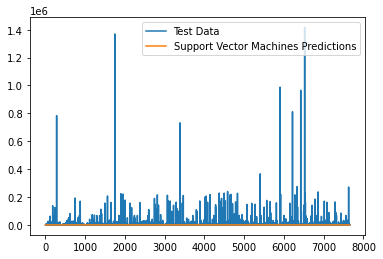

In [35]:
# predict and check against the testing data 
svm_estimator_pred = svm_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(svm_estimator_pred)
plt.legend(['Test Data', 'Support Vector Machines Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, svm_estimator_pred))
print('MSE:', mean_squared_error(out_conf_test, svm_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, svm_estimator_pred)))
print('R^2:', r2_score(out_conf_test, svm_estimator_pred))
#print("Accuracy:", accuracy_score(out_conf_test, svm_estimator_pred))
print(out_conf_test)
print(svm_estimator_pred)

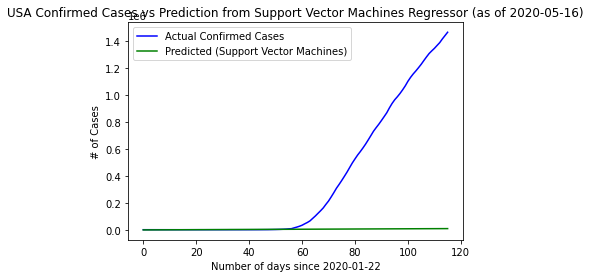

In [25]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = svm_estimator.predict(usa_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Support Vector Machines)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Support Vector Machines Regressor (as of {})".format(last_day))
plt.legend()